In [1]:
import numpy as np
from tools import generate_cfs, generate_bands, make_fir_filter

def spyral(input, fs, electrodes, n_carriers, spread, **kwargs):
    """Spyral: vocoder that utilizes multiple sinusoidal carriers to simulate current spread

        Parameters
        ----------
        input : array
            The input signal
        fs : scalar
            The sampling frequency
        electrodes : scalar or array
            If type==scalar, it represents the number of electrodes and each electrode will be 
            linearely distributed on an ERB scale between analysis_lo and analysis_hi.

            If type==array, each element represents the corresponding best frequency of each 
            electrode, and the number of electrodes is inferred from its length. Among other 
            things, this can be used to simulate warping, in which the cfs of analysis bands 
            may be different than the electrode positions.

        n_carriers : scalar
            Number of tone carriers
        spread : scalar
            Current spread [in -dB/Oct (negative!!)]. 
            Typical (Oxenham & Kreft 2014 + Nelson etal 2011) = -8 dB/octave.

        Kwargs
        ------
        analysis_lo : scalar 
            Lower bound of analysis filters, in Hz [default = 120 (Friesen et al.,2001)]
        analysis_hi : scalar 
            Upper bound of analysis filters, in Hz [default = 8658]
        carrier_lo : scalar 
            Lower bound of carriers, in Hz [default = 20]
        carrier_hi : scalar 
            Higher bound of carriers, in Hz [default = 20,000]
        analysis_cutoffs : array
            An array of cutoff frequencies to use. analysis_hi and lo are ignored. Must
            be one more than the number of electrodes.
        filt_env : scalar 
            Envelope filter cutoff, in Hz [default = 50]

        Returns
        -------
        out : array
            Vocoded input

        Example
        -------
        >>> out = spyral(signal, 44100, 20, 80, -8)

    """
    analysis_lo = kwargs.get('analysis_lo', 120) #人工耳蜗的频率界限
    analysis_hi = kwargs.get('analysis_hi', 8658)
    analysis_cutoffs = kwargs.get('analysis_cutoffs', None) #人工耳蜗的另一个指标，如果想要指定分析频率，比如，我们想指定人工耳蜗的电极分布不要按照平均分布
    carrier_lo = kwargs.get('carrier_lo', 20) #感受声音的细胞固有的分部
    carrier_hi = kwargs.get('carrier_hi', 20000) 
    filt_env = kwargs.get('filt_env', 50)
    in_phase = kwargs.get('in_phase', False)
    fs = np.float32(fs)

    rms_in = np.sqrt(np.mean(np.power(input, 2)))
    lp_filter = make_fir_filter(0, filt_env, fs)       # generate low-pass filter,  default 50Hz
    if np.isscalar(electrodes):
        cfs = np.array(generate_cfs(analysis_lo, analysis_hi, electrodes))     # electrodes' centre frequencies
    else:
        cfs = np.array(electrodes) # If not scalar, assume a list of cfs#电极分布序列
    carrier_fs = generate_cfs(carrier_lo, carrier_hi, n_carriers) # tone carrier frequencies，细胞分布序列
    t = np.arange(0, len(input) / fs, 1 / fs) #t的长度是采样个数，fs是采样频率，所以倒数就是周期，所以这个t就是一共从原始声音中采了多少样。
    t_carrier = np.zeros((n_carriers, len(input)))#这个是说每个神经细胞从原始声音中得到了多少声音，是矩阵

    #如果没有指定电极分布，那就用均匀分布
    #bug,bug,bug
    if analysis_cutoffs is None:
        ip_bands = analysis_cutoffs # User specified cutoffs
    else:
        ip_bands = np.array(generate_bands(analysis_lo, analysis_hi, cfs.size)) # lower/upper limits of each analysis band

    
    ip_bank = np.zeros((cfs.size, 512))
    envelope = np.zeros((cfs.size, len(input)))       # envelopes extracted per electrode
    mixed_envelope = np.zeros((n_carriers, len(input)))   # mixed envelopes to modulate carriers


    #采样核心代码
    # Envelope extraction
    for j in range(cfs.size):
        #ip_bands 采样带
        #ip_bank 电极数*512 0矩阵
        ip_bank[j, :] = make_fir_filter(ip_bands[j, 0], ip_bands[j, 1], fs)   # analysis filterbank
        speechband = np.convolve(input, ip_bank[j, :], mode='same')   #这里是把整个input和生成的ip_bands[j, 0]（长度为512）卷积一下
        envelope[j, :] = np.convolve(np.maximum(speechband,0), lp_filter, mode='same') # low-pass filter envelope#过滤掉低频率的声音
        #这里还要再看看文献，为啥会有这层卷积

    # weights applied to power envelopes
    for i in range(n_carriers):
        for j in range(cfs.size):
            mixed_envelope[i, :] += 10. ** (spread / 10. * np.abs(np.log2(cfs[j] / carrier_fs[i]))) * envelope[j, :] ** 2.

    # sqrt to get back to amplitudes
    mixed_envelope = np.sqrt(mixed_envelope)
    out = np.zeros(len(input))

    #细胞随机的相位移动问题，在这里我觉得不用考虑
    if in_phase:
        phases = np.zeros(n_carriers)
    else:
        phases = np.random.rand(n_carriers) * 2 * np.pi

    # Generate carriers, modulate; randomise tone phases (particularly important for binaural!)
    for i in range(n_carriers):
#        t_carrier[i, :] = np.sin(2 * np.pi * (carrier_fs[i] * t + np.random.rand()))
        t_carrier[i, :] = np.sin(phases[i] + (2. * np.pi * carrier_fs[i] * t))

        out += mixed_envelope[i, :] * t_carrier[i, :]             # modulate carriers with mixed envelopes
#    out = out * 0.05 * np.sqrt(len(out)) / np.linalg.norm(out)    # rms scaled, to avoid saturation
    return out * (np.sqrt(np.mean(np.square(input))) / np.sqrt(np.mean(np.square(out))))#最后做了一个归一化

In [2]:
import torch
import torch.nn.functional as F

import torch
import functools

def to_device(device):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            new_args = [arg.to(device) if isinstance(arg, torch.Tensor) else arg for arg in args]
            new_kwargs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in kwargs.items()}
            return func(*new_args, **new_kwargs)
        return wrapper
    return decorator

def conv1d_same(input_tensor, kernel_tensor):
    """
    Perform 1D convolution on input_tensor using kernel_tensor,
    mimicking the 'same' mode of np.convolve.
    
    Parameters:
        input_tensor (torch.Tensor): 1D input tensor.
        kernel_tensor (torch.Tensor): 1D kernel tensor.
    
    Returns:
        torch.Tensor: Output tensor after 1D convolution with same size as input_tensor.
    """
    if input_tensor.dim() != 1 or kernel_tensor.dim() != 1:
        raise ValueError("Both input_tensor and kernel_tensor must be 1D tensors.")
    
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, L]
    kernel_tensor = kernel_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, K]
    
    # Calculate the padding
    total_padding = kernel_tensor.size(2) - 1
    padding_left = total_padding // 2
    padding_right = total_padding - padding_left
    
    # Manually pad the input tensor
    padded_input_tensor = F.pad(input_tensor, (padding_left, padding_right))

    # Perform the convolution
    output_tensor = F.conv1d(padded_input_tensor, kernel_tensor)

    # Remove extra dimensions
    return output_tensor.squeeze()

In [3]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
begin_fc=120
end_fc=8658
depths=[-0.1,-0.1,-0.1,-0.05,-0.05,-0.05,0.,0.,0.,0.05,0.05,0.05,0.1,0.1,0.1]
electroids_num=12
exp=1

def adjust_length(tensor1, tensor2):
    len1 = tensor1.size(0)  # 获取第一个张量的长度
    len2 = tensor2.size(0)  # 获取第二个张量的长度
    
    if len2 > len1:
        # 如果第二个张量长度较长，进行截断
        return tensor2[:len1]
    elif len2 < len1:
        # 如果第二个张量长度较短，使用最后一个元素进行填充
        last_element = tensor2[-1].item()  # 获取最后一个元素
        padding = last_element * torch.ones(len1 - len2)  # 创建一个填充用的张量
        return torch.cat((tensor2, padding))  # 连接原始张量和填充张量
    else:
        # 长度相等，直接返回第二个张量
        return tensor2

def predict(sig,fs):
    #给定信号，频率输出通过模型预测的句子
    input_values = processor(sig, sampling_rate=fs, return_tensors="pt").input_values
    # INFERENCE

    # retrieve logits & take argmax
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # transcribe
    transcription = processor.decode(predicted_ids[0])
    # FINE-TUNE
    return (transcription)

def get_loss(sentense, sig, fs):
    input_values = processor(sig, sampling_rate=fs, return_tensors="pt").input_values
    # encode labels
    with processor.as_target_processor():
        labels = processor(sentense, return_tensors="pt").input_ids

    # compute loss by passing labels
    loss = model(input_values, labels=labels).loss
    return loss

def depth_adjust(cfs,depth=0):
    #move cfs to simulate different inplanting depth in insertion
    _depths=np.array([depth]*electroids_num)
    adjusted_depth=(35 / 2.1) * np.log10((np.array(cfs)/ 165.4) + 0.88)+_depths
    return 165.4 * (10**(2.1 * adjusted_depth / 35) - 0.88)

def apply_normal_variation(cfs):
#这里要改，改成cfs，因为cfs和bands有鲜明的对应关系，而且cfs容易变动，注意上限下限
    #bands=generate_bands(min(cfs),max(cfs),len(cfs))
    m=np.array([168]*(electroids_num))#经验矫正项，用于把cfs拉平成一个真正的直线
    cuts=list(np.log(cfs+m))
    # 计算变动的标准差，即原数值的百分比
    std_devs = [0.03]*electroids_num
    # 生成正态分布的随机变动
    variations = np.random.normal(0, std_devs)
    random_choose = random.sample(range(0, electroids_num), int(electroids_num/3))
    variations=[variations[i] if i in random_choose else 0 for i in range(electroids_num)]
    # 应用变动
    cuts = np.array(cuts) + np.array(variations)
    new_cfs=np.exp(cuts)-m
    if max(new_cfs)>=end_fc:
        new_cfs[-1]=end_fc-100
        new_cfs.sort()
    return new_cfs

def cfs_to_bands(cfs):
    m=np.array([168]*(electroids_num+1))#经验矫正项，用于把cfs拉平成一个真正的直线
    cuts=list(np.log(cfs+m[1:]))
    cuts=np.array([2*cuts[0]-cuts[1]]+cuts+[2*cuts[-1]-cuts[-2]])
    block=np.exp([(cuts[i]+cuts[i+1])/2 for i in range(0,electroids_num+1)])-m
    bands=[[block[i],block[i+1]] for i in range(0,len(block)-1)]
    return np.array(bands)

#read sound files
def read_sound():
    librispeech_samples_ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
    sig_ls=[]
    sentenses=[]
    for i in range(0,70):
        (sig,fs,enc) = pysndfile.sndio.read(librispeech_samples_ds[i]["file"])
        sig_ls.append(sig)
        sentenses.append(predict(sig,fs))
    return sentenses, sig_ls, fs

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/home/jyun/.conda/envs/bm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the mo

In [4]:
#try
from datasets import load_dataset
import pysndfile
(sentenses,sig_ls, fs)=read_sound()
cfs=np.array([170.24556885946038, 281.16463055116645, 463.51350221850475, 559.6087265485511, 893.4513581664048, 1185.8990951489839, 1557.4261013139158, 2084.603426844409, 2867.9235861370726, 3858.105079081676, 5368.54994216142, 7056.845799076047])

import time
start_time = time.time()

sig_out = spyral(sig_ls[0],fs,cfs, 80, -20)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

/home/jyun/.conda/envs/bm/lib/python3.8/site-packages/datasets/load.py:1486: FutureWarning: The repository for patrickvonplaten/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/patrickvonplaten/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


TypeError: 'NoneType' object is not subscriptable

In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from tools import generate_bands,generate_cfs

def predict_carriers(test_fc,patients_orignal_data,n_carriers):
    x = test_fc
    y = patients_orignal_data

    # 使用三次样条插值创建一个插值函数
    cs = CubicSpline(x, y)

    # 生成80个新的x值，用于计算相应的y值
    x_new = generate_cfs(begin_fc, end_fc, n_carriers)
    patients_predict_data = cs(x_new)
    # 可视化结果
    return patients_predict_data.reshape(-1, 1)

# 定义训练数据
n_carriers=80
begin_fc=120
end_fc=8658
electrodes=12
spread=-20

patients_orignal_data = torch.tensor([0.6,0.5,0.5,0.6,0.7,0.8,0.8,0.7,0.5,0.4], dtype=torch.float32)
test_fc = np.array([125,250,500,750,1000,1500,2000,4000,6000,8000])
patients_predict_data = predict_carriers(test_fc,patients_orignal_data,n_carriers=80) #M 1*80
W = torch.tensor(np.ones(electrodes), dtype=torch.float32,requires_grad=True) #1*12
cfs = np.array(generate_cfs(begin_fc, end_fc, electrodes))
carrier_fs = generate_cfs(begin_fc, end_fc, n_carriers)
# 定义损失函数
loss_fn = torch.nn.MSELoss()

# 定义优化器和超参数
optimizer = torch.optim.SGD([W], lr=1)
epochs = 10000
Y = np.zeros((n_carriers, cfs.size)) #权重 80*12
for i in range(n_carriers):
    for j in range(cfs.size): 
        Y[i,j]=10. ** (spread / 10. * np.abs(np.log2(cfs[j] / carrier_fs[i])))
Y=torch.tensor(Y)
patients_predict_data=torch.tensor(patients_predict_data)
# 批量梯度下降
for epoch in range(epochs):
    # 前向传播
    Y_pred = W * Y * patients_predict_data #12 80 12 80
    # 计算损失
    loss = loss_fn(Y_pred, Y)
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    # 清空梯度
    optimizer.zero_grad()

# 输出结果
W

tensor([1.8120, 2.0551, 2.0472, 1.8010, 1.5179, 1.3258, 1.2476, 1.2598, 1.3068,
        1.4113, 1.7128, 2.3464], requires_grad=True)

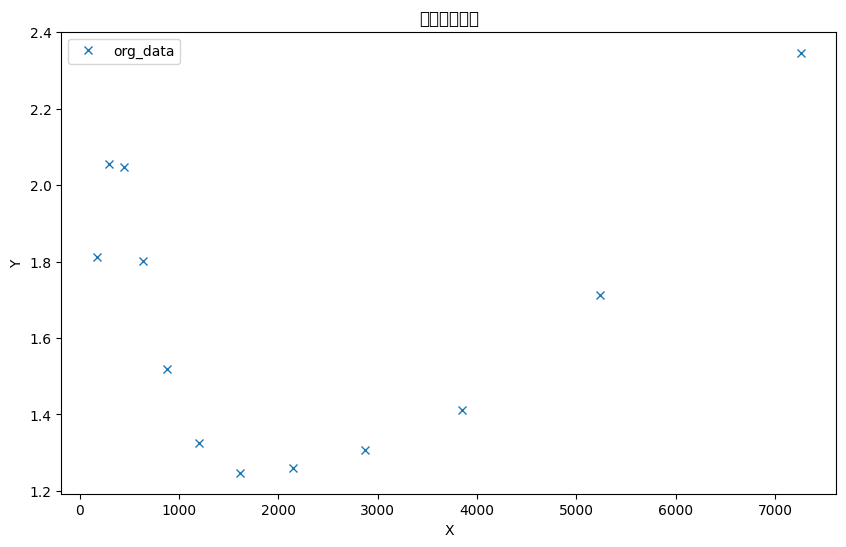

In [72]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def predict_carriers(test_fc,patients_orignal_data,n_carriers):
    x = test_fc
    y = patients_orignal_data

    # 使用三次样条插值创建一个插值函数
    cs = CubicSpline(x, y)

    # 生成80个新的x值，用于计算相应的y值
    x_new = np.linspace(0, max(test_fc), n_carriers)
    y_new = cs(x_new)
    # 可视化结果
    return y_new

# 定义训练数据
patients_orignal_data = torch.tensor([0.6,0.5,0.5,0.6,0.7,0.8,0.8,0.7,0.5,0.4], dtype=torch.float32)
test_fc = np.array([125,250,500,750,1000,1500,2000,4000,6000,8000])
patients_predict_data = predict_carriers(test_fc,patients_orignal_data,n_carriers=80)

plt.figure(figsize=(10, 6))
plt.plot(cfs, W.detach().numpy(), 'x')
#plt.plot(test_fc, patients_orignal_data, 'o', label='org_data')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Adjusted output sequence')
plt.show()


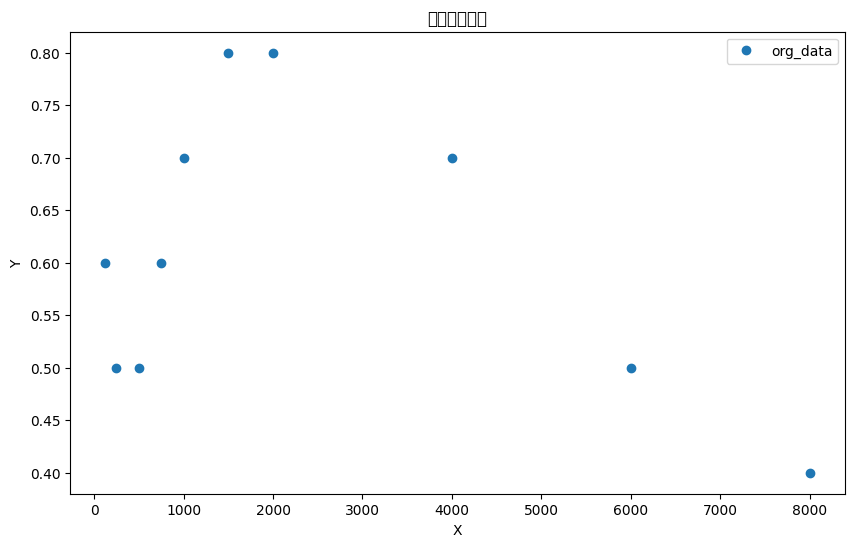

In [70]:
plt.figure(figsize=(10, 6))
#plt.plot(cfs, W.detach().numpy(), 'x', label='org_data')
plt.plot(test_fc, patients_orignal_data, 'o')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('patients cohlear condition')
plt.show()

In [10]:
begin_fc=120
end_fc=8658
electroids_num=12
exp=1

def read_sound():
    librispeech_samples_ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
    sig_ls=[]
    sentenses=[]
    for i in range(0,70):
        (sig,fs,enc) = pysndfile.sndio.read(librispeech_samples_ds[i]["file"])
        sig_ls.append(sig)
        sentenses.append(predict(sig,fs))
    return sentenses, sig_ls, fs
#try
#(sentenses,sig_ls, fs)=read_sound()
import time
start_time = time.time()

sig_out = spyral(sig_ls[1],fs,12, 80, -20)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

TypeError: 'NoneType' object is not subscriptable